In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
import tensorflow_hub as hub
from tensorflow.keras import layers
import pathlib
from PIL import  Image
from sklearn.model_selection import train_test_split
from Constants import *

In [2]:
dataset = keras.preprocessing.image_dataset_from_directory(
    DATA_PATH,
    shuffle = True,
    image_size = (image_size, image_size),
    batch_size = BATCH_SIZE
)

Found 1858 files belonging to 3 classes.


In [3]:
class_names = dataset.class_names
print(class_names)
num_classes = len(class_names)
print(num_classes)

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']
3


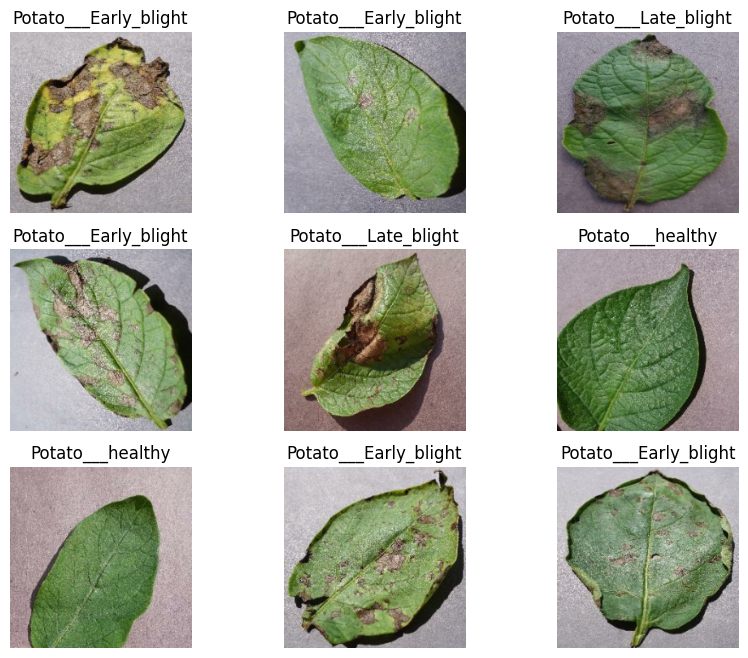

In [4]:
plt.figure(figsize = (10, 8))
for image_batch, label_batch in dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[label_batch[i]])
        plt.axis("off")

In [5]:
train_size = int(0.75 * len(dataset))
val_size = int(0.1 * len(dataset))
test_size = int(0.15 * len(dataset)) + 1

In [6]:
train_set = dataset.take(train_size)
test_set = dataset.skip(train_size)

In [7]:
val_set = test_set.take(val_size)
test_set = test_set.skip(val_size)

In [8]:
print(len(train_set))
print(len(test_set))
print(len(val_set))

44
10
5


In [9]:
train_set = train_set.cache().shuffle(1000).prefetch(buffer_size = AUTOTUNE)
test_set = test_set.cache().shuffle(1000).prefetch(buffer_size = AUTOTUNE)
val_set = val_set.cache().shuffle(1000).prefetch(buffer_size = AUTOTUNE)

In [10]:
resize_and_rescale = keras.Sequential([
    layers.experimental.preprocessing.Resizing(image_size, image_size),
    layers.experimental.preprocessing.Rescaling(1.0 / 255)
])

In [11]:
augmented_data = keras.Sequential([
    layers.RandomFlip("horizontal",
                      input_shape = (image_size, image_size,
                                     3)),
    layers.RandomRotation(0.25),
    layers.RandomZoom(0.35),
    layers.RandomFlip("horizontal_and_vertical")
])

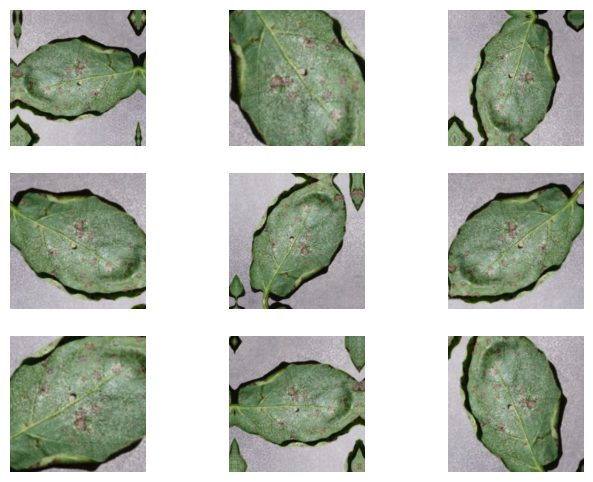

In [12]:
plt.figure(figsize = (8, 6))
for images, _ in train_set.take(1):
    for i in range(9):
        augmented_images = augmented_data(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

In [13]:
path = "../pretrained model/imagenet_mobilenet_v2_100_224_classification_5"

In [22]:
os.environ["TFHUB_CACHE_DIR"] = "/tmp/model"
pre_trained_layer = hub.KerasLayer(path,
                                   input_shape = (image_size, image_size, 3),
                                   trainable = True)

pre_trained_layer

In [24]:
input_shape = (BATCH_SIZE, image_size, image_size, num_classes)

model = keras.Sequential([    
    pre_trained_layer,
    layers.Dense(64, activation = 'relu'),
    layers.Dropout(0.25),
    layers.Dense(num_classes, activation = 'softmax'),    
])

model.build(input_shape = input_shape)

In [25]:
model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 224, 224, 3)         0         
                                                                 
 sequential_1 (Sequential)   (None, 224, 224, 3)       0         
                                                                 
 keras_layer_1 (KerasLayer)  (32, 1001)                3540265   
                                                                 
 dense_10 (Dense)            (32, 64)                  64128     
                                                                 
 dropout_15 (Dropout)        (32, 64)                  0         
                                                                 
 dense_11 (Dense)            (32, 3)                   195       
                                                                 
Total params: 3604588 (13.75 MB)
Trainable params: 357

In [26]:
model.compile(optimizer = 'adam',
              loss = 'sparse_categorical_crossentropy',
              metrics = ['accuracy'])

In [27]:
history = model.fit(train_set,
                    validation_data = val_set,
                    batch_size = BATCH_SIZE,
                    epochs = 12,
                    verbose = 1
                    )

Epoch 1/12


44/44 [==============================] - 413s 9s/step - loss: 0.5286 - accuracy: 0.8757 - val_loss: 3.6237 - val_accuracy: 0.6313
Epoch 2/12
44/44 [==============================] - 363s 8s/step - loss: 0.3103 - accuracy: 0.9425 - val_loss: 12.7627 - val_accuracy: 0.5625
Epoch 3/12
44/44 [==============================] - 347s 8s/step - loss: 0.2286 - accuracy: 0.9688 - val_loss: 2.1783 - val_accuracy: 0.8375
Epoch 4/12
44/44 [==============================] - 321s 7s/step - loss: 0.2361 - accuracy: 0.9624 - val_loss: 0.3008 - val_accuracy: 0.9563
Epoch 5/12
44/44 [==============================] - 292s 7s/step - loss: 0.2057 - accuracy: 0.9695 - val_loss: 0.5867 - val_accuracy: 0.9062
Epoch 6/12
44/44 [==============================] - 250s 6s/step - loss: 0.1882 - accuracy: 0.9794 - val_loss: 0.1829 - val_accuracy: 0.9937
Epoch 7/12
44/44 [==============================] - 254s 6s/step - loss: 0.2152 - accuracy: 0.9766 - val_loss: 0.1487 - val_accuracy: 0.9937
Epoch 8/12
44/44 [=====

In [28]:
loss = model.evaluate(test_set)
loss

10/10 [==============================] - 11s 851ms/step - loss: 0.2791 - accuracy: 0.9586


[0.27911099791526794, 0.9586206674575806]

In [29]:
history = history.history

In [30]:
acc = history['accuracy']
val_acc = history['val_accuracy']

loss = history['loss']
val_loss = history['val_loss']

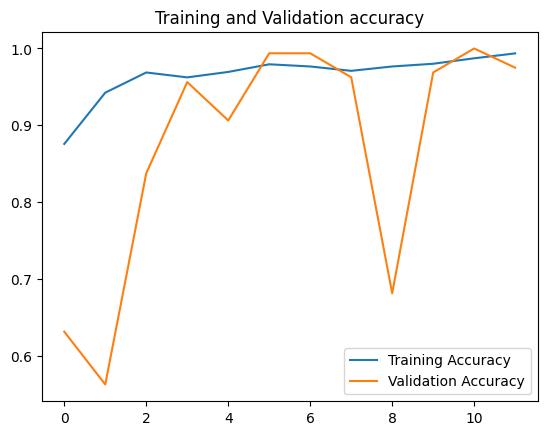

In [31]:
plt.plot(acc, label = "Training Accuracy")
plt.plot(val_acc, label = "Validation Accuracy")
plt.legend(loc = 'lower right')
plt.title("Training and Validation accuracy")
plt.show()

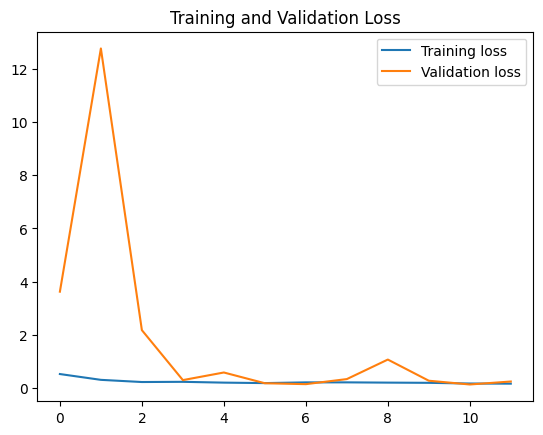

In [32]:
plt.plot(loss, label = "Training loss")
plt.plot(val_loss, label = "Validation loss")
plt.legend(loc = 'upper right')
plt.title("Training and Validation Loss")
plt.show()

In [33]:
model.save("../saved_models/4")

INFO:tensorflow:Assets written to: ../saved_models/4\assets


INFO:tensorflow:Assets written to: ../saved_models/4\assets


In [34]:
model = tf.keras.models.load_model("../saved_models/4")

Checking...
1/1 [==============================] - 2s 2s/step
Predicted label:  Potato___Late_blight
Actual label: Potato___Late_blight

Prediction matches!


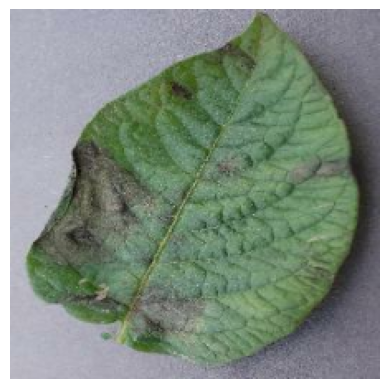

In [35]:
for images_batch, labels_batch in test_set.take(1):
    displayed_image = images_batch[0].numpy().astype("uint8")
    image_label = labels_batch[0].numpy()
    
    print("Checking...")
    plt.imshow(displayed_image)
    plt.axis("off")
    image_prediction = model.predict(images_batch)
    actual = class_names[np.argmax(image_prediction[0])]
    predicted = class_names[image_label]
    print("Predicted label: ", actual)
    print("Actual label:", predicted)
    
    if actual == predicted:
        print("\nPrediction matches!")
    else:
        print("\nWrong prediction!")

#### Predicting on test directory

In [36]:
eb = "../testing_images/early_blight"
lb = "../testing_images/late_blight"
h = "../testing_images/healthy"

e_b = os.listdir(eb)
l_b = os.listdir(lb)
h_l = os.listdir(h)

class_labels = ["early_blight", "late_blight", "healthy"]

In [37]:
eb_label = [0] * len(e_b)
lb_label = [1] * len(l_b)
h_label  = [2] * len(h_l)

label = eb_label + lb_label + h_label

In [38]:
data = []
for img in e_b:
    image = Image.open("../testing_images/early_blight/" + img)
    image = image.resize((image_size, image_size))
    image = np.array(image)
    data.append(image)
    
for img in l_b:
    image = Image.open("../testing_images/late_blight/" + img)
    image = image.resize((image_size, image_size))
    image = np.array(image)
    data.append(image)
    
for img in h_l:
    image = Image.open("../testing_images/healthy/" + img)
    image = image.resize((image_size, image_size))
    image = np.array(image)
    data.append(image)

In [39]:
X = np.array(data)
y = np.array(label)

X_train, _, y_train, _ = train_test_split(X, y, test_size = 0.001)

print(X_train.shape)
print(y_train.shape)

(306, 224, 224, 3)
(306,)


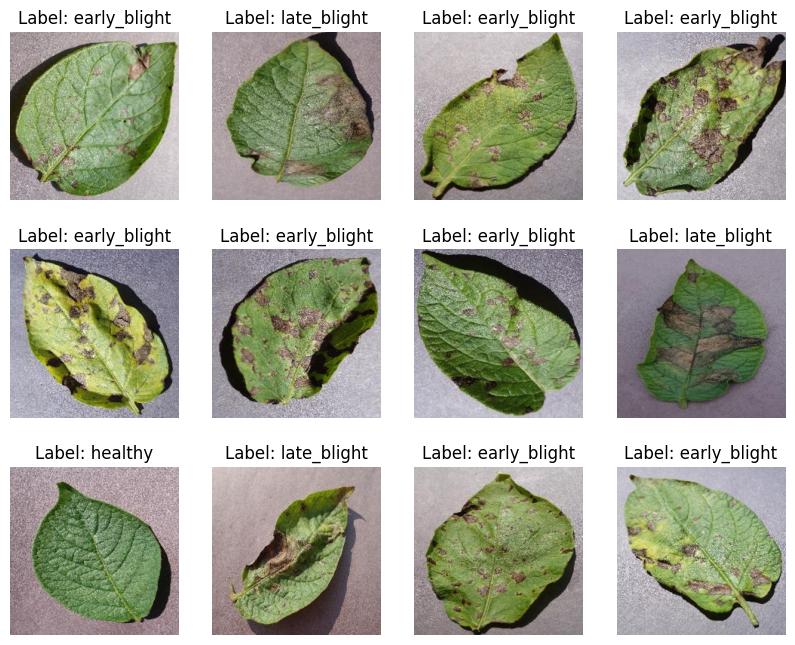

In [40]:
plt.figure(figsize=(10, 8))
for i in range(0, 12):
        plt.subplot(3, 4, i+1)
        plt.imshow(X_train[i])
        plt.title(f"Label: {class_labels[y_train[i]]}")
        plt.axis("off")

In [41]:
y_pred = model.predict(X_train)
y_pred_label = [np.argmax(i) for i in y_pred]

10/10 [==============================] - 10s 875ms/step


In [42]:
a = y_pred_label[:]
np.hstack(a)
b = y_train[:]
a == b

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True, False, False,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
       False,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True, False,  True, False,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True, False,

In [43]:
elem = 0
for x, y in zip(a, b):
    if x == y:
        elem += 1
print(f"Correctly predicted {elem} out of {len(a)} test images.")
print(f"{(elem / len(a)) * 100} %")

Correctly predicted 293 out of 306 test images.
95.75163398692811 %


Correctly predicted 58 out of 60 displayed test images,
2 incorrect predictions


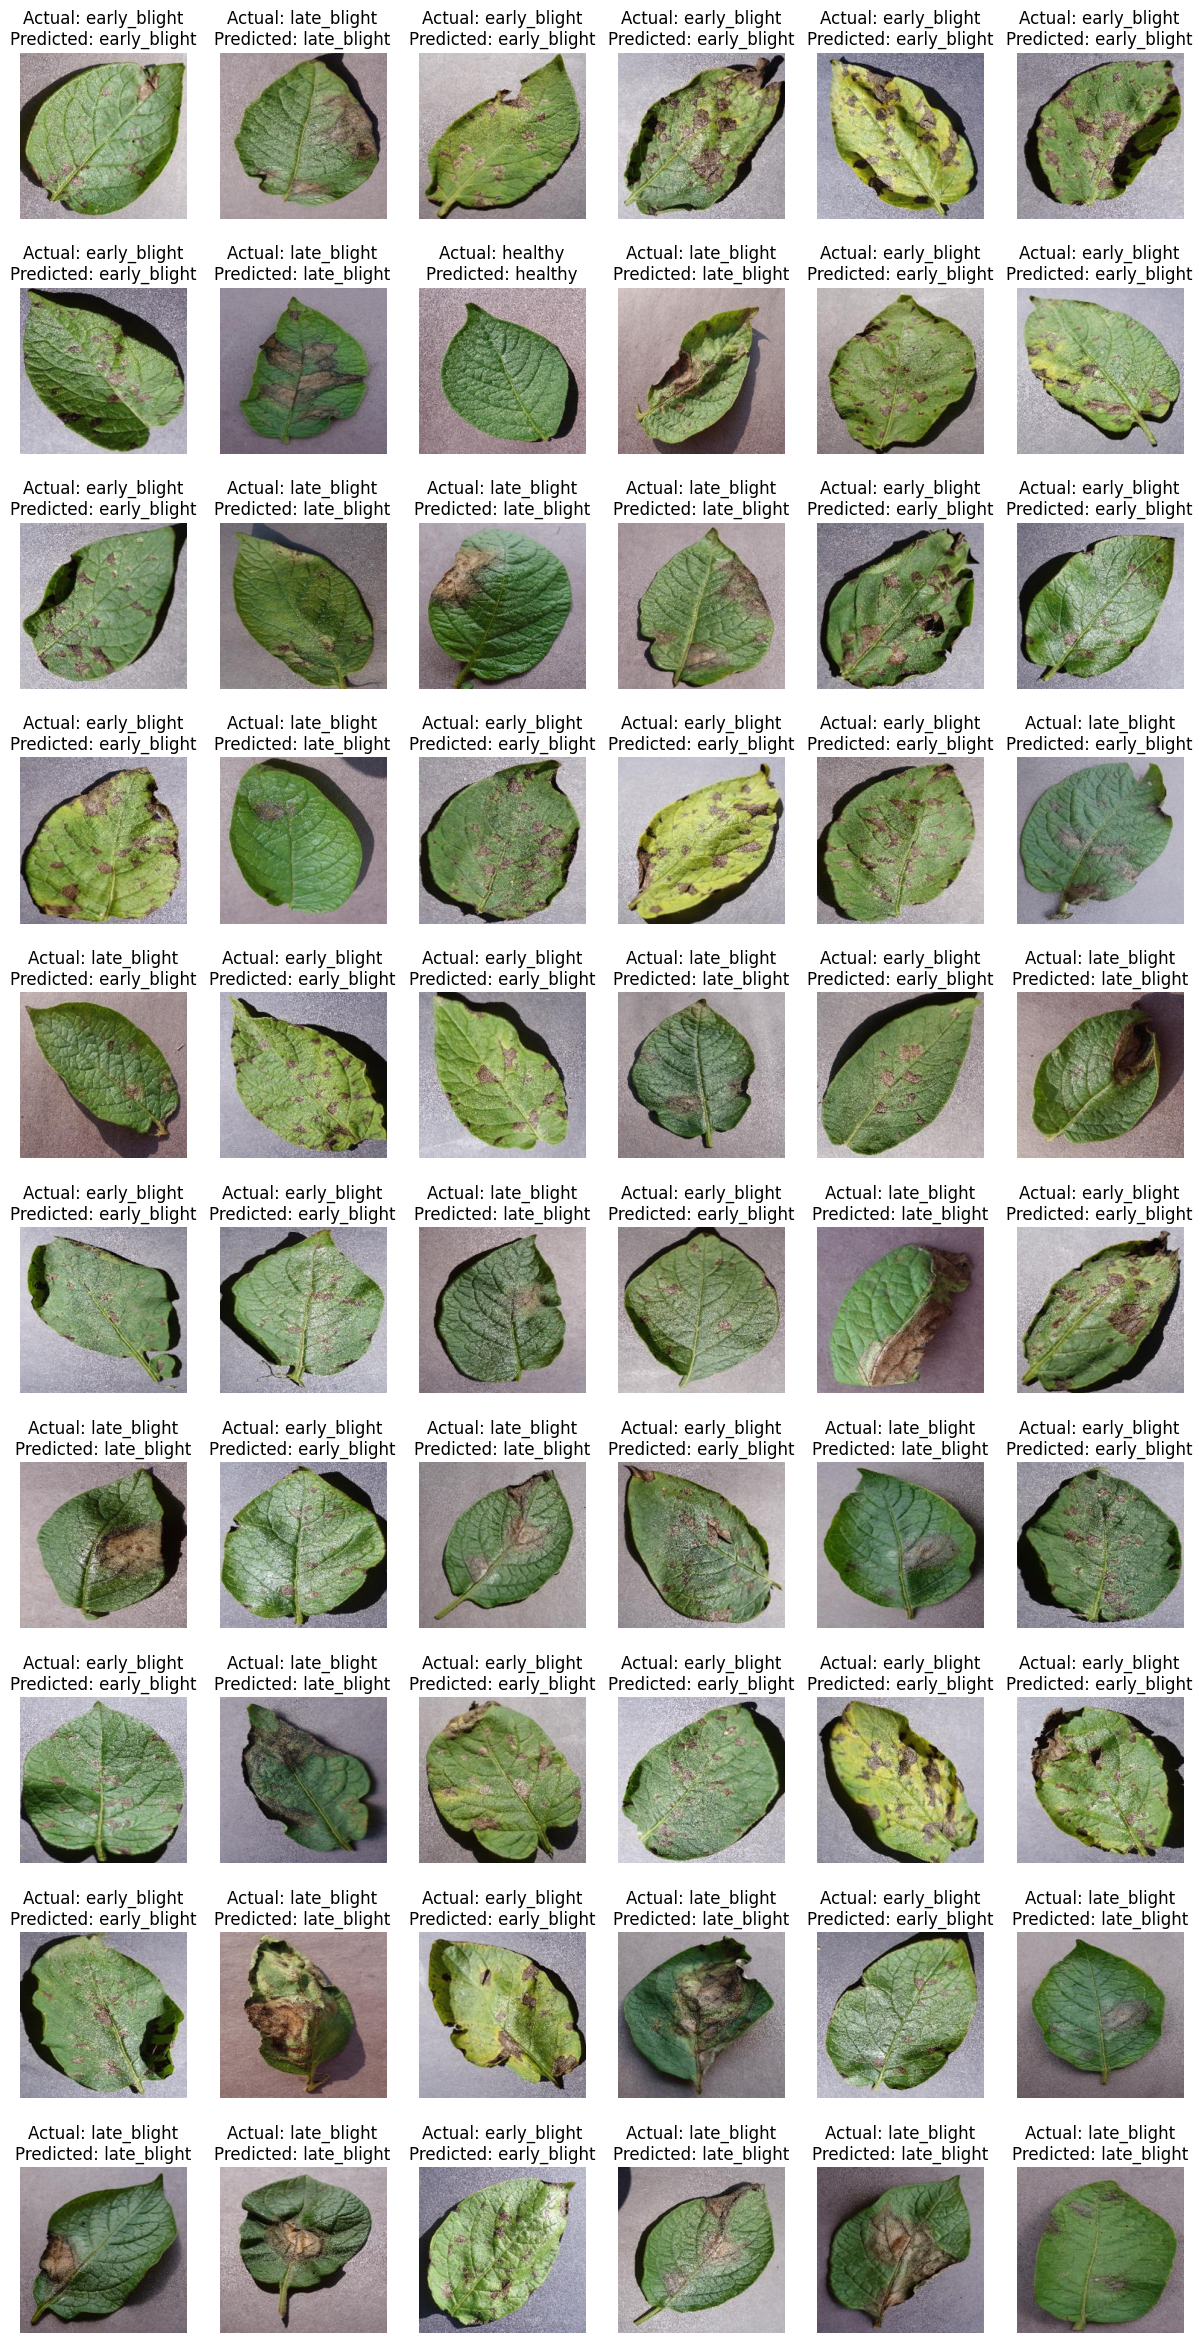

In [44]:
correct_count = 0
total = 60
incorrect_count = 0

plt.figure(figsize=(15, 30))
for i in range(0, total):
    plt.subplot(10, 6, i + 1)
    plt.imshow(X_train[i])
    plt.title(f"Actual: {class_labels[y_train[i]]}\nPredicted: {class_labels[y_pred_label[i]]}")
    plt.axis("off")
    if class_labels[y_train[i]] == class_labels[y_pred_label[i]]:
        correct_count += 1
    else:
        incorrect_count += 1
print(f"Correctly predicted {correct_count} out of {total} displayed test images,\n{incorrect_count} incorrect predictions")